In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score,train_test_split,cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_log_error,root_mean_squared_error

In [130]:
dtypes={
    'Price (in €)': float,
    'Total_area (square meters)': float,
    'Floor': float,
    'House_type': 'category',
    'Location_aprox': 'category',
    'Rooms': float,
    'Bathrooms': float,

}
df = pd.read_csv("./Houses_data_final.csv", 
                 dtype=dtypes,
                 parse_dates=['submission_date'])



In [131]:
df.drop(columns=["Location","submission_date"], inplace=True)


In [132]:
df

,Total_area (square meters),Price (in €),House_type,Floor,Rooms,Bathrooms,Year_of_construction,autonomous_heating,central_heating,individual_heating,...,with_elavator,with_solar_heater,with_fireplace,Furnished,with_parking,with_garden,with_pool,with_balcony,last_floor,Location_aprox
0,70.0,245000.0,Διαμέρισμα,7.0,2.0,1.0,1952,1,0,0,...,1,1,0,1,0,0,0,0,1,Vardaris_xirokrini
1,30.0,123000.0,Studio / Γκαρσονιέρα,4.0,1.0,1.0,1952,1,0,0,...,1,0,0,1,0,0,0,1,0,Center_west_of_including_aristotle_square
2,39.0,173000.0,Studio / Γκαρσονιέρα,4.0,1.0,1.0,1952,0,0,0,...,0,0,0,0,0,0,0,1,0,out_of_thessaloniki
3,30.0,132000.0,Studio / Γκαρσονιέρα,4.0,1.0,1.0,1952,0,0,0,...,1,0,0,1,0,0,0,0,0,Center_west_of_including_aristotle_square
4,39.0,173000.0,Studio / Γκαρσονιέρα,4.0,1.0,1.0,1952,1,0,0,...,1,0,0,1,0,1,0,0,0,Center_west_of_including_aristotle_square
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20760,85.0,170000.0,Διαμέρισμα,0.0,2.0,1.0,2024,1,0,0,...,0,1,0,0,1,0,0,0,0,Efkarpia_Nikopoli
20761,87.0,170000.0,Διαμέρισμα,0.0,2.0,2.0,2024,1,0,0,...,0,0,0,0,1,1,0,1,0,Efkarpia_Nikopoli
20762,145.0,240000.0,Μεζονέτα,2.0,3.0,1.0,2024,1,0,0,...,1,0,0,0,1,0,0,1,1,Efkarpia_Nikopoli
20763,45.0,95000.0,Studio / Γκαρσονιέρα,2.0,1.0,1.0,2024,1,0,0,...,1,0,0,0,1,0,0,1,1,Efkarpia_Nikopoli


In [10]:
df.dtypes

Total_area (square meters)     float64
Price (in €)                   float64
House_type                    category
Floor                          float64
Rooms                          float64
Bathrooms                      float64
Year_of_construction             int64
autonomous_heating               int64
central_heating                  int64
individual_heating               int64
no_heating                       int64
petrol_heating                   int64
natural_gas_heating              int64
LPG_heating                      int64
electrical_heating               int64
thermal_storage_heating          int64
wood_headting                    int64
pellet_heating                   int64
heat_pump_heating                int64
with_AC                          int64
with_storage_room                int64
with_elavator                    int64
with_solar_heater                int64
with_fireplace                   int64
Furnished                        int64
with_parking             

We will split our data in training and validation sets. But first let us encode the categorical features.

In [133]:
X=df.copy().drop(columns=["Price (in €)"])
y=df.copy().pop("Price (in €)")


In [134]:
def label_encode(df,one_hot=False):
    X = df.copy()
    if one_hot:
        cat_columns = X.select_dtypes(["category"]).columns
        X = pd.get_dummies(X, columns=cat_columns, drop_first=True,dtype=int)
        return X   
    else:
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
        return X
X= label_encode(X)

In [135]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Establishing a baseline

First we will establish a baseline model which we will use to evaluate our subsequent models. Notice that we use Round Mean Squared Logarithmic Error (RMSLE) is our cost function. There are many reasons for that. We mention the three most important ones here:

1)House prices are typically right-skewed. There are many affordable houses and fewer very expensive, luxury properties. This means the distribution of sale prices is not normal; it has a long tail towards higher values.

2)RMSE penalizes absolute errors. If you have a house priced at €100,000 and you're off by €10,000, that's an error of 10%. If you have a house priced at €1,000,000 and you're off by €10,000, that's an error of 1%. RMSE would treat both €10,000 errors equally, even though the relative impact is vastly different.

3)Log transformation "normalizes" the skewness. By taking the logarithm of the prices, the distribution often becomes more symmetrical (closer to a normal distribution). This is beneficial for many regression models that assume normally distributed errors or linear relationships.

In [233]:
def baseline_model(X, y,model=XGBRegressor(reg_alpha=0.1, reg_lambda=1.0)):

    log_y = np.log(y)
    score = cross_validate(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",return_train_score=True

    )
    score_test= -1 * score.get("test_score").mean()
    score_test = np.sqrt(score_test)
    score_train = -1 * score.get("train_score").mean()
    score_train = np.sqrt(score_train)
    return score_test, score_train
    

In [ ]:
baseline_test,baseline_train=baseline_model(X_train, y_train)
print(f"Baseline RMSLE validation and train errors using Boosting: {baseline_test,baseline_train}")
print(f"Baseline RMSLE validation and train errors using Random Forest: {baseline_model(X_train, y_train, model=RandomForestRegressor())}")


Baseline RMSLE test and train errors using Boosting: (np.float64(0.2675215607626756), np.float64(0.1830783084556426))
Baseline RMSLE test and train errors using Random Forest: (np.float64(0.28588660884280465), np.float64(0.10872794616755241))


In [ ]:
X_regr=label_encode(df.copy().drop(columns=["Price (in €)"]), one_hot=True)
X_regr_train,X_regr_test,y_regr_train,y_regr_test=train_test_split(X_regr,y,test_size=0.2,random_state=42)
print (f"Baseline RMSLE validation and train errors using Linear Regression: {baseline_model(X_regr_train, y_regr_train, model=LinearRegression())}")

Baseline RMSLE test and train errors using Linear Regression: (np.float64(0.3524564346813539), np.float64(0.3494080278098977))


# Feature Engineering

In the next section we will try to engineer features that are going to improve the performance of our models.

It seems that Boosting is the most promising method to use for this problem so this will be our default. First we will use [mutual information](https://en.wikipedia.org/wiki/Mutual_information) to select features that are most relevant to the target variable which is the house price in our case. 

In [235]:
def make_mi_scores(X, y):
    X = X.copy()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [236]:
mi_scores = round(make_mi_scores(X_train, y_train),2)



In [237]:
print(mi_scores)

Total_area (square meters)    0.83
Rooms                         0.39
Location_aprox                0.34
Year_of_construction          0.31
House_type                    0.27
Floor                         0.23
Bathrooms                     0.20
with_fireplace                0.13
with_parking                  0.11
with_garden                   0.07
with_storage_room             0.07
with_elavator                 0.05
natural_gas_heating           0.03
electrical_heating            0.03
petrol_heating                0.03
with_balcony                  0.02
Furnished                     0.02
with_solar_heater             0.02
last_floor                    0.02
autonomous_heating            0.01
no_heating                    0.01
individual_heating            0.01
with_AC                       0.01
thermal_storage_heating       0.00
LPG_heating                   0.00
with_pool                     0.00
central_heating               0.00
heat_pump_heating             0.00
wood_heating        

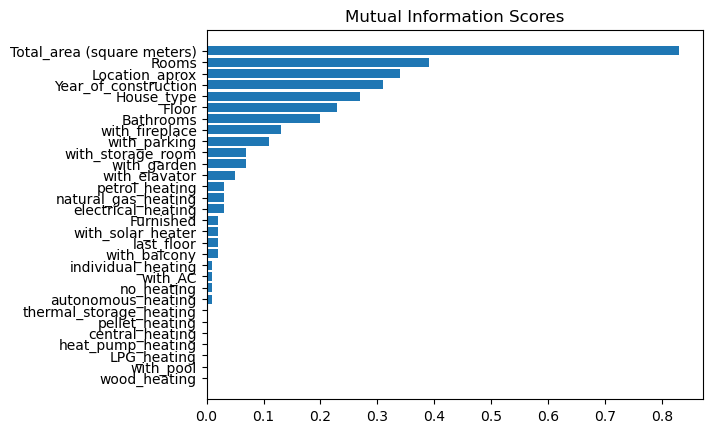

In [238]:

plot_mi_scores(mi_scores)

We drop the features with mutual information zero. Notice though that the error did not improve much.

In [142]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [152]:


X_no_uninform = drop_uninformative(X_train, mi_scores)


print(baseline_model(X_no_uninform, y_train))

(np.float64(0.27008119031381156), np.float64(0.17994181194702513))


We will also draw the correlation matrix to visualize the relationships between features.

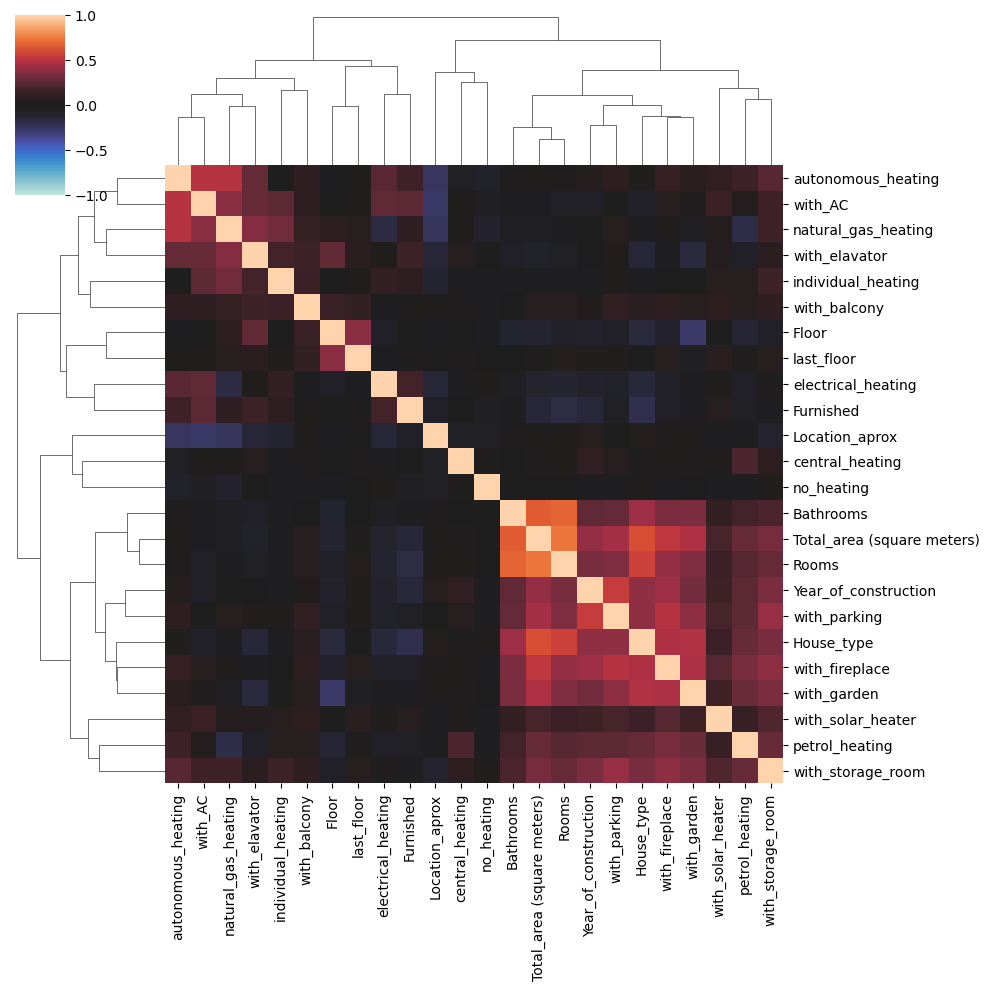

In [39]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(X_no_uninform, annot=None)


Next we will develop our feature set. We are going to create functions that will add features to our data set. We describe what each function does.

**counts:** This functions simply counts the number of attributes from the list 
        "with_AC",
        "with_storage_room",
        "with_elavator",
        "with_solar_heater",
        "with_fireplace",
        "with_parking",
        "with_garden",
        "with_pool",
        "with_balcony",
        "last_floor" 
each house has and returns a column with that number.

**group_transforms:** This function creates a new column which contains the average total area of houses located in the same place (location_aprox column) as the specified row.

**mathematical_transforms:** This function creates a new column which contains the average area of each room in the house.

In [239]:
def counts(df):
    X = pd.DataFrame()
    X["Number_of_extras"] = df[[
        
        "with_storage_room",
        "with_elavator",
        
        "with_fireplace",
        "with_parking",
        "with_garden",
    ]].sum(axis=1)
    return X
def group_transforms(df):
    X = pd.DataFrame()
    X["Mean_total_area_per_loc"] = df.groupby("Location_aprox")["Total_area (square meters)"].transform("median")
    X["Mean_total_age_per_loc"] = df.groupby("Location_aprox")["Age"].transform("median")
    X["Mean_total_area_per_type"] = df.groupby("House_type")["Total_area (square meters)"].transform("median")
    return X
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    #X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df["Total_area (square meters)"]) / (df["Rooms"])
    X["Age"]= df["Year_of_construction"].apply(lambda x: 2025-x)

    return X

Next we are going to use target encoding to create a new feature.

In [342]:
def target_encode(df, groupby_col):
    """This function performs target encoding on a specified column, groupby_col, of a DataFrame df based on the target variable."""
    df_features=df.copy().drop(columns=["Price (in €)"])
    target=df.copy().pop("Price (in €)")
    df_train, target_train, df_test,target_test=train_test_split(df_features, target, test_size=0.2, random_state=42)
    target_encoder = TargetEncoder(target_type="continuous", cv=5, smooth=5, random_state=42)
    X_enc_train = target_encoder.fit_transform(df_train.loc[:, groupby_col].to_numpy().reshape(-1, 1), target_train.values)
    encoded_col = [f"{col}_encoded" for col in groupby_col]
    X_enc_test = target_encoder.transform(df_test.loc[:, groupby_col].to_numpy().reshape(-1, 1))
    X_enc_train = pd.DataFrame(X_enc_train, columns=encoded_col, index=df_train.index)
    X_enc_test = pd.DataFrame(X_enc_test, columns=encoded_col, index=df_test.index)
    df_final=pd.concat([X_enc_train, X_enc_test])
    return df_final

We will also use the [Kmeans clustering algorithm](https://scikit-learn.org/stable/modules/clustering.html#k-means) to create new features based on the distance of each house from the cluster centroids.

In [241]:

cluster_features = [
    "Total_area (square meters)",
    "House_type",
    "Year_of_construction",
    "Location_aprox",
    "Rooms"

]


def cluster_distance(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

Next we will use PCA (Principal Component Analysis) to create new features.

In [148]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X,)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names,index=X.index)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca
pca_features = [
    "Total_area (square meters)",
    "Year_of_construction",
    "Bathrooms",
    "Rooms",
    "Floor",
]

In [46]:
pca, X_pca, loadings = apply_pca(X_no_uninform[pca_features])
print(loadings)

                                 PC1       PC2       PC3       PC4       PC5
Total_area (square meters)  0.551897  0.060464 -0.054064 -0.480411 -0.676784
Year_of_construction        0.339610 -0.105122  0.916374  0.168043  0.075062
Bathrooms                   0.519182  0.080480 -0.318549  0.782679 -0.099566
Rooms                       0.543496  0.148821 -0.178284 -0.356326  0.723679
Floor                      -0.123032  0.978094  0.155169  0.037574 -0.052013


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

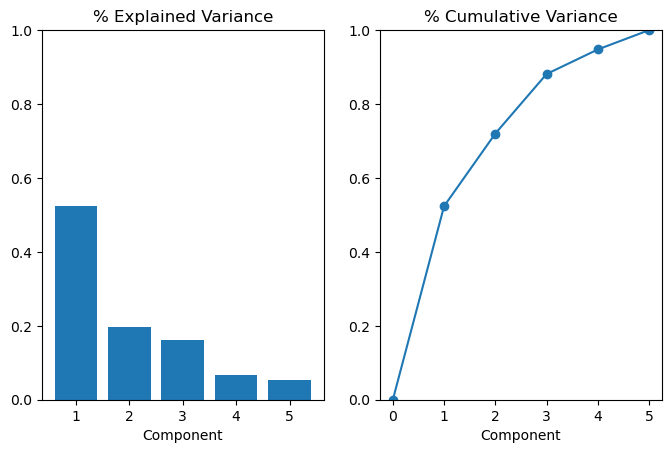

In [47]:
plot_variance(pca)

It is time now to create the desired features and add them to our data. Putting the transformations into separate functions makes it easier to experiment with various combinations. We have applied the transformations that gave the best results.

Baseline RMSLE (validation, train): (0.26418371670484136, 0.18234477597607404)


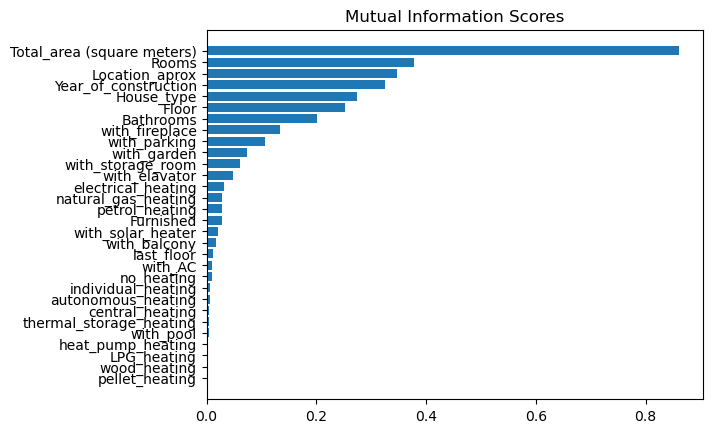

In [356]:
def create_features(df):
    X = df.copy()
    y = X.pop("Price (in €)")
    


    X = label_encode(X)
    mi_scores = make_mi_scores(X, y)
    plot_mi_scores(mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    #X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    #X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    
    X=pd.get_dummies(X, columns=["Location_aprox"], drop_first=True, dtype=int)
    
    #Target Encoder
    # X=target_encode(df,groupby_col=["Location_aprox"])
    return X

X= create_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


score_test,score_train=baseline_model(X_train, y_train)
print(f"Baseline RMSLE (validation, train): {float(score_test), float(score_train)}")

Next we are going to finetune our model by using optuna.

In [353]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    val_error,train_error=baseline_model(X_train, y_train, xgb)
    return val_error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2025-08-13 18:02:43,286] A new study created in memory with name: no-name-4f99b049-24a8-4cb8-9ca8-46661d43a521
[I 2025-08-13 18:03:38,181] Trial 0 finished with value: 0.26374178214848076 and parameters: {'max_depth': 7, 'learning_rate': 0.06007557410084882, 'n_estimators': 4685, 'min_child_weight': 2, 'colsample_bytree': 0.49479164299539297, 'subsample': 0.9407844302580872, 'reg_alpha': 0.00016945998709372005, 'reg_lambda': 0.7793101788434201}. Best is trial 0 with value: 0.26374178214848076.
[I 2025-08-13 18:04:20,583] Trial 1 finished with value: 0.3462848017372273 and parameters: {'max_depth': 7, 'learning_rate': 0.0010782605620538754, 'n_estimators': 4935, 'min_child_weight': 1, 'colsample_bytree': 0.5914813081828716, 'subsample': 0.6851642935615176, 'reg_alpha': 82.29953711040865, 'reg_lambda': 1.2715015977680098}. Best is trial 0 with value: 0.26374178214848076.
[I 2025-08-13 18:05:27,747] Trial 2 finished with value: 0.264785745598648 and parameters: {'max_depth': 9, 'learni

In [354]:
xgb_params

{'max_depth': 10,
 'learning_rate': 0.013377340109287914,
 'n_estimators': 6464,
 'min_child_weight': 4,
 'colsample_bytree': 0.439191529906408,
 'subsample': 0.9957256516316615,
 'reg_alpha': 0.00848740136109104,
 'reg_lambda': 0.1944038830906744}

In [358]:

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but our loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y_train))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('predictions.csv', index=False)
print("Your predictions were successfully saved!")

Your predictions were successfully saved!
